# 프로젝트 : 멋진 단어사진 만들기
============================================================================

## 목차
>### 1. 데이터 불러오기
>### 2. 데이터 전처리
>### 3. Sentence piece unigram 모델 구성하기
>### 4. Sentence piece unigram 모델 학습하기
>### 5. Sentence piece unigram 모델 결과 확인
>### 6. Sentence piece BPE 모델 구성 및 학습
>### 6.1 결과 확인하기
>### 7. 다른 형태소 분석기 사용하기
>>### 7.1 Mecab 모델
>>### 7.2 Komoran 모델
>>### 7.3 Okt 모델
>### 8. 종합 결과 확인
>### 9. 회고
>### 10. Reference
>### 11. 자기다짐 및 아쉬운 점

---
## 루브릭 달성 조건
1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?
    - 코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?
2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?
    - SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.
3. SentencePiece의 성능을 다각도로 비교분석하였는가?
    - SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.
---

## 1. 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import konlpy
import re
from tqdm import tqdm
from konlpy.tag import Mecab, Okt, Komoran
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
import warnings
warnings.filterwarnings('ignore')


tf.random.set_seed(42)
np.random.seed(42)

In [2]:
train_path = './data/ratings_train.txt'
test_path = './data/ratings_test.txt'

train = pd.read_table(train_path, sep='	',usecols=['id', 'document', 'label'], encoding='UTF-8')
test = pd.read_table(test_path, sep='	',usecols=['id', 'document', 'label'], encoding='UTF-8')

In [3]:
train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
test.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


- 예전에 사용했었던 네이버 감성리뷰 데이터셋을 가져왔습니다.

In [5]:
# 중복 제거
train.drop_duplicates(subset=['document'], inplace=True)
test.drop_duplicates(subset=['document'], inplace=True)

In [6]:
print('train 데이터셋 결측치 갯수','\n\n', train.isna().sum(), '\n', '----'*32, '\n')
print('test 데이터셋 결측치 갯수', '\n\n', test.isna().sum())

train 데이터셋 결측치 갯수 

 id          0
document    1
label       0
dtype: int64 
 -------------------------------------------------------------------------------------------------------------------------------- 

test 데이터셋 결측치 갯수 

 id          0
document    1
label       0
dtype: int64


In [7]:
# 결측치 제거
train.dropna(inplace=True)
test.dropna(inplace=True)

In [8]:
train_len = len(train)

In [9]:
# id 컬럼 제거
data = pd.concat([train, test], axis=0)

del data['id']

In [10]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

document = np.array(data['document'])
label = np.array(data['label'])
document = document[indices]
label = label[indices]

- 데이터를 랜덤한 값으로 셔플해주었습니다.

In [11]:
data['document'] = document
data['label'] = label

In [12]:
train, test = data[:train_len], data[train_len:]

In [13]:
train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

print('train 데이터셋의 길이', len(train))
print('test 데이터셋의 길이', len(test))

train 데이터셋의 길이 146182
test 데이터셋의 길이 49157


- 중복값을 제거하니 약 4천개의 데이터가 사라졌습니다.

---
## 2. 데이터 전처리

In [14]:
def regex_sentence(corpus):
    sentences = []
    for sentence in corpus:
        sentence = re.sub(r"[^a-zA-Zㅋㅎㅜㅠ가-힣0-9!;?.,]+", r"", sentence)
        sentences.append(sentence)
    corpus = sentences
    
    return corpus

- 전처리 함수를 만들었습니다. 영어, 한글은 남겨놓고 자음 ㅋㅎ 모음 ㅜㅠ 가 단독적으로 사용된 경우를 제외하곤 삭제했습니다. 특수문자는 !;?., 를 제외하고 삭제하였습니다.

In [15]:
train['document'] = regex_sentence(train['document'])
test['document'] = regex_sentence(test['document'])

In [17]:
import sentencepiece as spm
import os

temp_file = os.getenv('HOME')+'/aiffel/Going_Deeper/GD_02/data/korean-english-park.train.ko.temp'

vocab_size = 25000

pad_id = 0
bos_id = 1
eod_id = 2
unk_id = 3
max_length = 40
train_large_corpus = True

with open(temp_file, 'w') as f:
    for row in train['document']:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} \
    --model_prefix=korean_spm_unigram_custom \
    --vocab_size={} \
    --pad_id={} \
    --bos_id={} \
    --eos_id={} \
    --unk_id={} \
    --max_sentence_length={}\
    --train_extremely_large_corpus={}'.format(temp_file, vocab_size, pad_id, bos_id, eod_id, unk_id, max_length, train_large_corpus)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm_unigram_custom*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/Going_Deeper/GD_02/data/korean-english-park.train.ko.temp     --model_prefix=korean_spm_unigram_custom     --vocab_size=25000     --pad_id=0     --bos_id=1     --eos_id=2     --unk_id=3     --max_sentence_length=40    --train_extremely_large_corpus=True
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/Going_Deeper/GD_02/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm_unigram_custom
  model_type: UNIGRAM
  vocab_size: 25000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 40
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whit

-rw-r--r-- 1 root root 740709 Nov 22 04:06 korean_spm_unigram_custom.model
-rw-r--r-- 1 root root 525063 Nov 22 04:06 korean_spm_unigram_custom.vocab
-rw-r--r-- 1 root root 509171 Nov 21 11:54 korean_spm_unigram.model
-rw-r--r-- 1 root root 284903 Nov 21 11:54 korean_spm_unigram.vocab


- SPM 모델을 가져왔습니다. 파라미터에서 토큰의 값을 지정해주고 문장 최대길이를 지정해주었습니다.

In [18]:
s_uni = spm.SentencePieceProcessor()
s_uni.Load('korean_spm_unigram.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s_uni.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s_uni.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s_uni.DecodeIds(tokensIDs))

[3, 7263, 294, 18, 3377, 122, 9, 4]
['▁', '아버지가', '방', '에', '들어가', '신', '다', '.']
아버지가방에들어가신다.


- load가 잘 된것을 확인할 수 있습니다.

In [19]:
def sp_tokenize(s, df, df2):

    tensor = []
    tensor2 = []

    for sen in df['document']:
        tensor.append(s.EncodeAsIds(sen))
    
    for sen2 in df2['document']:
        tensor2.append(s.EncodeAsIds(sen2))        

    with open("./korean_spm_unigram_custom.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    train_label = np.array(df['label'])
    test_label = np.array(df2['label'])

    return tensor, train_label, tensor2, test_label, word_index, index_word

- LMS 예시 tokenize 함수를 가져와서 살짝 커스텀하였습니다.

In [20]:
x_train, y_train, x_test, y_test, uni_word_to_idx, uni_idx_to_word = sp_tokenize(s_uni, train, test)

In [21]:
def max_min_len(data, name):
    max_len = 0
    min_len = 999
    total_len = 0

    for i in tqdm(range(len(data))):
        if len(data[i]) < min_len:
            min_len = len(data[i])
            total_len += len(data[i])
        elif len(data[i]) > max_len:
            max_len = len(data[i])
            total_len += len(data[i])
        elif len(data[i]) >= min_len or len(data[i]) <= max_len:
            total_len += len(data[i])
    mean_len = total_len//len(data)
    
    print(f'{name} 데이터셋의 최대 길이: {max_len}')
    print(f'{name} 데이터셋의 최소 길이: {min_len}')
    print(f'{name} 데이터셋의 평균 길이: {mean_len}')
    print(f'{name} 데이터셋의 총 길이: {total_len}')
    print('----'*32)
    
    sentence_length = np.zeros((max_len), dtype=np.int)

    for s in data:
        sentence_length[len(s)-1] += 1

    plt.bar(range(max_len), sentence_length, width=1.0)
    plt.title("{} Length".format(name))
    plt.show()

- 데이터 최대길이, 최소길이, 평균길이 분포를 구해주는 함수를 설정하였습니다.

100%|██████████| 146182/146182 [00:00<00:00, 1166423.63it/s]


Train 데이터셋의 최대 길이: 98
Train 데이터셋의 최소 길이: 0
Train 데이터셋의 평균 길이: 14
Train 데이터셋의 총 길이: 2081717
--------------------------------------------------------------------------------------------------------------------------------


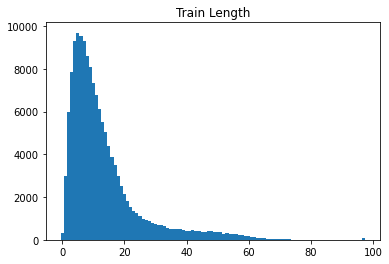

100%|██████████| 49157/49157 [00:00<00:00, 1645157.80it/s]


Test 데이터셋의 최대 길이: 103
Test 데이터셋의 최소 길이: 0
Test 데이터셋의 평균 길이: 14
Test 데이터셋의 총 길이: 709557
--------------------------------------------------------------------------------------------------------------------------------


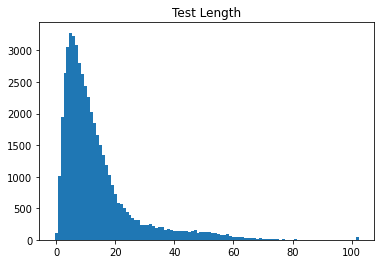

In [22]:
max_min_len(x_train, 'Train')
max_min_len(x_test, 'Test')

In [23]:
def clear_sentence(x_train, y_train, min_num = 0, max_num = 25000, name='Train'):
    orig_train_len = len(x_train)
    train = []
    train_label = []
    for i in tqdm(reversed(range(len(x_train)))):
        if len(x_train[i]) <= min_num or len(x_train[i]) > max_num:
            continue
        else:
            train.append(x_train[i])
            train_label.append(y_train[i])
    
    print('----'*32)                    
    print(f'전처리 전 {name} 데이터의 길이: {orig_train_len}')
    print(f'전처리 후 {name} 데이터의 길이: {len(train)}')
    print('----'*32)
    train = np.array(train)
    train_label = np.array(train_label)
    
    return train, train_label

- 분포에 맞게 문장의 길이를 조절해줄 함수를 만들었습니다.

In [24]:
x_train, y_train = clear_sentence(x_train, y_train, min_num = 1, max_num=25)
x_test, y_test = clear_sentence(x_test, y_test, min_num=1, max_num = 25, name='Test')

146182it [00:00, 933664.31it/s]


--------------------------------------------------------------------------------------------------------------------------------
전처리 전 Train 데이터의 길이: 146182
전처리 후 Train 데이터의 길이: 127433
--------------------------------------------------------------------------------------------------------------------------------


49157it [00:00, 994114.76it/s]


--------------------------------------------------------------------------------------------------------------------------------
전처리 전 Test 데이터의 길이: 49157
전처리 후 Test 데이터의 길이: 42679
--------------------------------------------------------------------------------------------------------------------------------


- 방해가되는 길이 1의 데이터는 삭제하고 길이가 25을 넘는 데이터도 삭제하였습니다.
- 데이터가 약 train은 2만개 test는 6500개가 삭제되었습니다.

100%|██████████| 127433/127433 [00:00<00:00, 862112.88it/s]


Train 데이터셋의 최대 길이: 25
Train 데이터셋의 최소 길이: 2
Train 데이터셋의 평균 길이: 10
Train 데이터셋의 총 길이: 1343040
--------------------------------------------------------------------------------------------------------------------------------


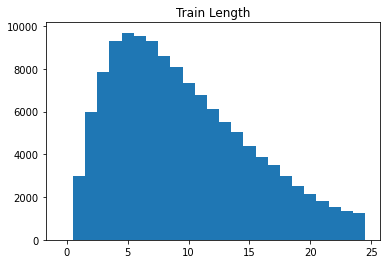

100%|██████████| 42679/42679 [00:00<00:00, 795799.36it/s]


Test 데이터셋의 최대 길이: 25
Test 데이터셋의 최소 길이: 2
Test 데이터셋의 평균 길이: 10
Test 데이터셋의 총 길이: 452850
--------------------------------------------------------------------------------------------------------------------------------


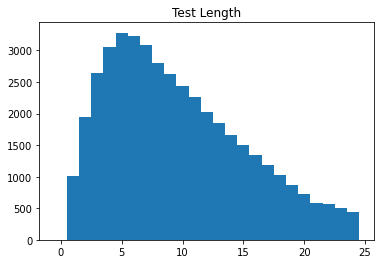

In [25]:
max_min_len(x_train, 'Train')
max_min_len(x_test, 'Test')

- 잘 처리되었군요.

In [26]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, padding='post', maxlen= 25)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, padding='post', maxlen= 25)

- 패딩도 동일하게 25로 진행해주었습니다.

In [27]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  random_state=42)

In [28]:
print(' 훈련 데이터셋의 길이: ',len(x_train),'\n', '벨리데이션 데이터셋의 길이: ', len(x_val))
print('----'*32)
print(' 훈련 라벨데이터셋의 길이: ', len(y_train), '\n', '벨리데이션 라벨데이터셋의 길이: ', len(y_val))
print('----'*32)

 훈련 데이터셋의 길이:  101946 
 벨리데이션 데이터셋의 길이:  25487
--------------------------------------------------------------------------------------------------------------------------------
 훈련 라벨데이터셋의 길이:  101946 
 벨리데이션 라벨데이터셋의 길이:  25487
--------------------------------------------------------------------------------------------------------------------------------


- train과 validation 셋을 8:2로 나누어 주었습니다.

---
## 3. Sentence piece unigram 모델 구성하기

In [29]:
# 하이퍼 파라미터
vocab_size = 25000
embedding_size = 64
batch_size = 256
units = 32
epochs = 5
drop_rate = 0.5

In [30]:
class s_uni_model(keras.Model):
    def __init__(self, vocab_size, embedding_size, units, drop_rate):
        super().__init__()
        self.Embedding = Embedding(vocab_size, embedding_size, mask_zero=True)
        self.lstm1 = LSTM(units, return_sequences=True, activation='tanh', dropout=drop_rate)
        self.batch1 = BatchNormalization()
        self.drop1 = Dropout(drop_rate)
        self.lstm2 = LSTM(units*2, activation='tanh', dropout=drop_rate)
        self.batch2 = BatchNormalization()
        self.drop2 = Dropout(drop_rate)
        self.dense = Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.Embedding(x)
        x = self.lstm1(x)
        x = self.batch1(x)
        x = self.drop1(x)
        x = self.lstm2(x)
        x = self.batch2(x)
        x = self.drop2(x)
        x = self.dense(x)
        
        return x

- subclassing 방식으로 모델을 만들었습니다.

---
## 4. Sentence piece unigram 모델 학습하기

In [31]:
s_uni_model = s_uni_model(vocab_size, embedding_size, units, drop_rate)

s_uni_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

s_uni_history = s_uni_model.fit(x_train, y_train, batch_size=batch_size,\
                    verbose='auto', epochs=epochs,\
                    validation_data=(x_val, y_val), callbacks=[es])

Epoch 1/5
399/399 [==============================] - 91s 203ms/step - loss: 0.5727 - accuracy: 0.7151 - val_loss: 0.4810 - val_accuracy: 0.8352
Epoch 2/5
399/399 [==============================] - 80s 200ms/step - loss: 0.3659 - accuracy: 0.8470 - val_loss: 0.3498 - val_accuracy: 0.8489
Epoch 3/5
399/399 [==============================] - 79s 199ms/step - loss: 0.3246 - accuracy: 0.8650 - val_loss: 0.3509 - val_accuracy: 0.8507
Epoch 4/5
399/399 [==============================] - 79s 197ms/step - loss: 0.2989 - accuracy: 0.8749 - val_loss: 0.3483 - val_accuracy: 0.8512
Epoch 5/5
399/399 [==============================] - 79s 199ms/step - loss: 0.2799 - accuracy: 0.8837 - val_loss: 0.3609 - val_accuracy: 0.8496


- 학습은 5epochs만 진행하였습니다.

---
## 5. Sentence piece unigram 모델 결과 확인

In [32]:
s_uni_test = s_uni_model.evaluate(x_test, y_test, verbose=2)

1334/1334 - 17s - loss: 0.3556 - accuracy: 0.8524


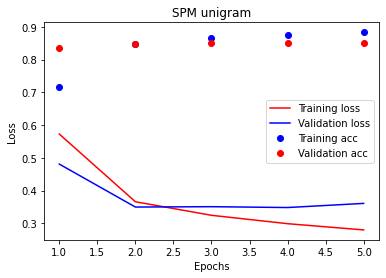

In [33]:
s_uni_history_dict = s_uni_history.history

s_uni_acc = s_uni_history_dict['accuracy']
s_uni_val_acc = s_uni_history_dict['val_accuracy']
s_uni_loss = s_uni_history_dict['loss']
s_uni_val_loss = s_uni_history_dict['val_loss']

epoch = range(1, len(s_uni_acc) + 1)

plt.plot(epoch, s_uni_loss, 'r', label='Training loss')
plt.plot(epoch, s_uni_val_loss, 'b', label='Validation loss')
plt.plot(epoch, s_uni_acc, 'bo', label='Training acc')
plt.plot(epoch, s_uni_val_acc, 'ro', label='Validation acc')
plt.title('SPM unigram')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- loss도 우하향하는 모습을 보여주며 accuracy도 상승하는 모습을 보여주나 어느정도 overfitting을 완전히 잡지는 못한듯한 모습을 보여줍니다.
- 그래도 test 데이터셋에 대해서도 85% 의 정확도를 보여줍니다.

---
## 6. Sentence piece BPE 모델 구성 및 학습

In [34]:
# with open(temp_file, 'w') as f:
#     for row in train['document']:
#         f.write(str(row) + '\n')

# spm.SentencePieceTrainer.Train(
#     '--input={} --model_prefix=korean_spm_bpe --model_type=bpe --vocab_size={}'.format(temp_file, vocab_size)    
# )

# !ls -l korean_spm_bpe*

In [35]:
# s_bpe = spm.SentencePieceProcessor()
# s_bpe.Load('korean_spm_bpe.model')

# tokensIDs = s_bpe.EncodeAsIds('아버지가방에들어가신다.')
# print(tokensIDs)

# print(s_bpe.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# print(s_bpe.DecodeIds(tokensIDs))

In [36]:
# x_train, y_train, bpe_word_to_idx, bpe_idx_to_word = sp_tokenize(s_bpe, train)
# x_test, y_test, _, _ = sp_tokenize(s_bpe, test)

In [37]:
# max_min_len(x_train, 'Train')
# max_min_len(x_test, 'Test')

In [38]:
# x_train, y_train = clear_sentence(x_train, y_train, min_num = 1, max_num=25)
# x_test, y_test = clear_sentence(x_test, y_test, min_num=1, max_num = 25, name='Test')

In [39]:
# max_min_len(x_train, 'Train')
# max_min_len(x_test, 'Test')

In [40]:
# x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, padding='post', maxlen= 25)
# x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, padding='post', maxlen= 25)

In [41]:
# x_train, x_val, y_train, y_val = train_test_split(x_train,
#                                                   y_train,
#                                                   test_size=0.2,
#                                                   random_state=42)

In [42]:
# print(' 훈련 데이터셋의 길이: ',len(x_train),'\n', '벨리데이션 데이터셋의 길이: ', len(x_val))
# print('----'*32)
# print(' 훈련 라벨데이터셋의 길이: ', len(y_train), '\n', '벨리데이션 라벨데이터셋의 길이: ', len(y_val))
# print('----'*32)

In [43]:
# class s_bpe_model(keras.Model):
#     def __init__(self, vocab_size, embedding_size, units):
#         super().__init__()
#         self.Embedding = Embedding(vocab_size, embedding_size, mask_zero=True)
#         self.lstm1 = LSTM(units, return_sequences=True, activation='tanh')
#         self.batch1 = BatchNormalization()
#         self.drop1 = Dropout(0.3)
#         self.lstm2 = LSTM(units*2, return_sequences=True, activation='tanh')
#         self.batch2 = BatchNormalization()
#         self.drop2 = Dropout(0.3)
#         self.lstm3 = LSTM(units*4, activation = 'tanh')
#         self.batch3 = BatchNormalization()
#         self.drop3 = Dropout(0.3)
#         self.dense = Dense(1, activation='sigmoid')
        
#     def call(self, x):
#         x = self.Embedding(x)
#         x = self.lstm1(x)
#         x = self.batch1(x)
#         x = self.drop1(x)
#         x = self.lstm2(x)
#         x = self.batch2(x)
#         x = self.drop2(x)
#         x = self.lstm3(x)
#         x = self.batch3(x)
#         x = self.drop3(x)
#         x = self.dense(x)
        
#         return x

In [44]:
# s_bpe_model = s_bpe_model(vocab_size, embedding_size, units)

# s_bpe_model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)

# s_bpe_history = s_bpe_model.fit(x_train, y_train, batch_size=batch_size,\
#                     verbose='auto', epochs=epochs,\
#                     validation_data=(x_val, y_val), callbacks=[es])

---
## 6.1 결과 확인하기

In [45]:
# s_bpe_history_dict = s_bpe_history.history

# s_bpe_acc = s_bpe_history_dict['accuracy']
# s_bpe_val_acc = s_bpe_history_dict['val_accuracy']
# s_bpe_loss = s_bpe_history_dict['loss']
# s_bpe_val_loss = s_bpe_history_dict['val_loss']

# epoch = range(1, len(s_bpe_acc) + 1)

# plt.plot(epoch, s_bpe_loss, 'r', label='Training loss')
# plt.plot(epoch, s_bpe_val_loss, 'b', label='Validation loss')
# plt.plot(epoch, s_bpe_acc, 'bo', label='Training acc')
# plt.plot(epoch, s_bpe_val_acc, 'ro', label='Validation acc')
# plt.title('SPM BPE')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.show()

- BPE 모델은 load가 되지않아 실습해보지 못했습니다.

---
## 7. 다른 형태소 분석기 사용하기

## 7.1 Mecab 모델

In [46]:
def mecab_token(df, df2, num_words = 25000):
    mecab = Mecab()
    x_train = []
    
    df_len = len(df)
    df = pd.concat([df, df2], axis=0)
    df.reset_index(inplace=True)
    
    for i in tqdm(range(len(df))):
        x_train.append(mecab.morphs(df['document'][i]))
        
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words, filters=" ", char_level=True)
    
    tokenizer.fit_on_texts(x_train)
    
    
    x_train = tokenizer.texts_to_sequences(x_train)
    x_train = np.array(list(x_train))
    
    x_train, x_test = x_train[:df_len], x_train[df_len:]
    y_train, y_test = np.array(df['label'][:df_len]), np.array(df['label'][df_len:])
    
    return x_train, y_train, x_test, y_test, tokenizer

- mecab tokenizer 함수를 만들었습니다.

In [47]:
x_train, y_train, x_test, y_test, mecab_token = mecab_token(train, test)

100%|██████████| 195339/195339 [00:24<00:00, 8012.82it/s]


In [48]:
mecab_word_to_idx = {}
mecab_idx_to_word = {}
for i, v in mecab_token.index_word.items():
    mecab_word_to_idx[v] = i
    mecab_idx_to_word[i] = v

- word_to_idx 사전과 idx_to_word 사전을 만들었습니다.

100%|██████████| 146182/146182 [00:00<00:00, 847344.56it/s]


Train 데이터셋의 최대 길이: 116
Train 데이터셋의 최소 길이: 0
Train 데이터셋의 평균 길이: 17
Train 데이터셋의 총 길이: 2615982
--------------------------------------------------------------------------------------------------------------------------------


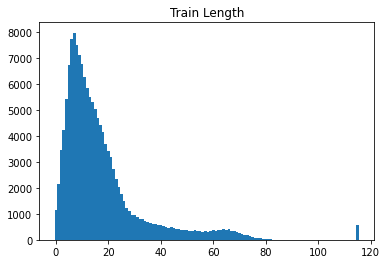

100%|██████████| 49157/49157 [00:00<00:00, 806850.70it/s]


Test 데이터셋의 최대 길이: 98
Test 데이터셋의 최소 길이: 0
Test 데이터셋의 평균 길이: 18
Test 데이터셋의 총 길이: 886790
--------------------------------------------------------------------------------------------------------------------------------


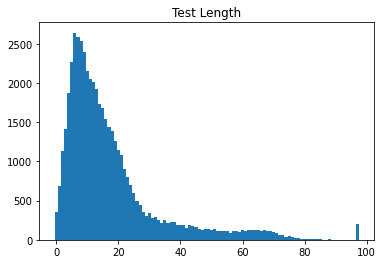

In [49]:
max_min_len(x_train, 'Train')
max_min_len(x_test, 'Test')

- 길이 분포로 약 25가 적당해보이는군요

In [50]:
x_train, y_train = clear_sentence(x_train, y_train, min_num = 1, max_num = 25)
x_test, y_test = clear_sentence(x_test, y_test, min_num = 1, max_num = 25, name='Test')

146182it [00:00, 970132.89it/s]


--------------------------------------------------------------------------------------------------------------------------------
전처리 전 Train 데이터의 길이: 146182
전처리 후 Train 데이터의 길이: 117631
--------------------------------------------------------------------------------------------------------------------------------


49157it [00:00, 877919.53it/s]

--------------------------------------------------------------------------------------------------------------------------------
전처리 전 Test 데이터의 길이: 49157
전처리 후 Test 데이터의 길이: 39433
--------------------------------------------------------------------------------------------------------------------------------


In [51]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, padding='post', maxlen= 25)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, padding='post', maxlen= 25)

- 길이분포 조절을 해주고 패딩을 해주었습니다.

In [52]:
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  random_state=42)

In [53]:
print(' 훈련 데이터셋의 길이: ',len(x_train),'\n', '벨리데이션 데이터셋의 길이: ', len(x_val))
print('----'*32)
print(' 훈련 라벨데이터셋의 길이: ', len(y_train), '\n', '벨리데이션 라벨데이터셋의 길이: ', len(y_val))
print('----'*32)

 훈련 데이터셋의 길이:  94104 
 벨리데이션 데이터셋의 길이:  23527
--------------------------------------------------------------------------------------------------------------------------------
 훈련 라벨데이터셋의 길이:  94104 
 벨리데이션 라벨데이터셋의 길이:  23527
--------------------------------------------------------------------------------------------------------------------------------


In [54]:
class mecab_model(keras.Model):
    def __init__(self, vocab_size, embedding_size, units, drop_rate):
        super().__init__()
        self.Embedding = Embedding(vocab_size, embedding_size, mask_zero=True)
        self.lstm1 = LSTM(units, return_sequences=True, activation='tanh', dropout=drop_rate)
        self.batch1 = BatchNormalization()
        self.drop1 = Dropout(drop_rate)
        self.lstm2 = LSTM(units*2, activation='tanh', dropout=drop_rate)
        self.batch2 = BatchNormalization()
        self.drop2 = Dropout(drop_rate)
        self.dense = Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.Embedding(x)
        x = self.lstm1(x)
        x = self.batch1(x)
        x = self.drop1(x)
        x = self.lstm2(x)
        x = self.batch2(x)
        x = self.drop2(x)
        x = self.dense(x)
        
        return x

- Sentencepiece와 동일한 모델을 사용하였습니다.

In [55]:
mecab_model = mecab_model(vocab_size, embedding_size, units, drop_rate)

mecab_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

mecab_history = mecab_model.fit(x_train, y_train, batch_size=batch_size,\
                    verbose='auto', epochs=epochs,\
                    validation_data=(x_val, y_val), callbacks=[es])

Epoch 1/5
368/368 [==============================] - 20s 29ms/step - loss: 0.5517 - accuracy: 0.7406 - val_loss: 0.5021 - val_accuracy: 0.8382
Epoch 2/5
368/368 [==============================] - 8s 21ms/step - loss: 0.3728 - accuracy: 0.8398 - val_loss: 0.3569 - val_accuracy: 0.8428
Epoch 3/5
368/368 [==============================] - 8s 21ms/step - loss: 0.3269 - accuracy: 0.8623 - val_loss: 0.3643 - val_accuracy: 0.8449
Epoch 4/5
368/368 [==============================] - 8s 21ms/step - loss: 0.2983 - accuracy: 0.8740 - val_loss: 0.3762 - val_accuracy: 0.8462
Epoch 5/5
368/368 [==============================] - 8s 21ms/step - loss: 0.2755 - accuracy: 0.8853 - val_loss: 0.3768 - val_accuracy: 0.8474


In [56]:
mecab_test = mecab_model.evaluate(x_test, y_test, verbose=2)

1233/1233 - 7s - loss: 0.3836 - accuracy: 0.8442


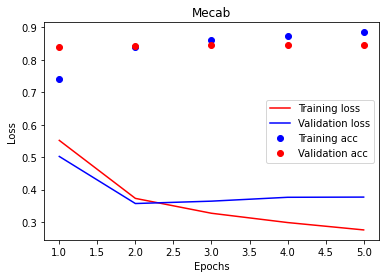

In [57]:
mecab_history_dict = mecab_history.history

mecab_acc = mecab_history_dict['accuracy']
mecab_val_acc = mecab_history_dict['val_accuracy']
mecab_loss = mecab_history_dict['loss']
mecab_val_loss = mecab_history_dict['val_loss']

epoch = range(1, len(mecab_acc) + 1)

plt.plot(epoch, mecab_loss, 'r', label='Training loss')
plt.plot(epoch, mecab_val_loss, 'b', label='Validation loss')
plt.plot(epoch, mecab_acc, 'bo', label='Training acc')
plt.plot(epoch, mecab_val_acc, 'ro', label='Validation acc')
plt.title('Mecab')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- 약 84%라는 좋은 수치를 이끌어냈군요.
- 그래프도 약간 아쉽지만 나쁘지 않습니다.

---
## 7.2 Komoran 모델

In [58]:
def komoran_token(df, df2, num_words = 25000):
    komoran = Komoran()
    x_train = []
    
    df_len = len(df)
    df = pd.concat([df, df2], axis=0)
    df.reset_index(inplace=True)
    
    for i in tqdm(range(len(df))):
        x_train.append(komoran.morphs(df['document'][i]))
        
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words, filters=" ", char_level=True)
    
    tokenizer.fit_on_texts(x_train)
    
    
    x_train = tokenizer.texts_to_sequences(x_train)
    x_train = np.array(list(x_train))
    
    x_train, x_test = x_train[:df_len], x_train[df_len:]
    y_train, y_test = np.array(df['label'][:df_len]), np.array(df['label'][df_len:])
    
    return x_train, y_train, x_test, y_test, tokenizer

In [59]:
x_train, y_train, x_test, y_test, komoran_token = komoran_token(train, test)

100%|██████████| 195339/195339 [02:52<00:00, 1131.21it/s]


In [60]:
komoran_word_to_idx = {}
komoran_idx_to_word = {}
for i, v in komoran_token.index_word.items():
    komoran_word_to_idx[v] = i
    komoran_idx_to_word[i] = v

100%|██████████| 146182/146182 [00:00<00:00, 971924.47it/s]


Train 데이터셋의 최대 길이: 109
Train 데이터셋의 최소 길이: 0
Train 데이터셋의 평균 길이: 14
Train 데이터셋의 총 길이: 2172621
--------------------------------------------------------------------------------------------------------------------------------


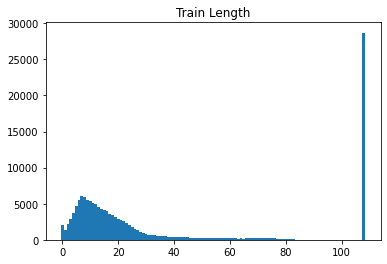

100%|██████████| 49157/49157 [00:00<00:00, 987472.89it/s]


Test 데이터셋의 최대 길이: 108
Test 데이터셋의 최소 길이: 0
Test 데이터셋의 평균 길이: 14
Test 데이터셋의 총 길이: 736782
--------------------------------------------------------------------------------------------------------------------------------


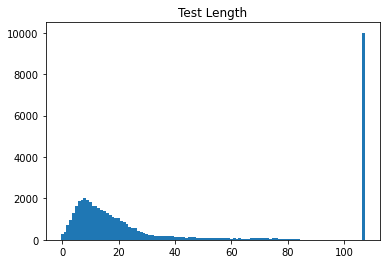

In [61]:
max_min_len(x_train, 'Train')
max_min_len(x_test, 'Test')

In [62]:
x_train, y_train = clear_sentence(x_train, y_train, min_num = 1, max_num = 20)
x_test, y_test = clear_sentence(x_test, y_test, min_num = 1, max_num = 20, name='Test')

146182it [00:00, 965478.18it/s]


--------------------------------------------------------------------------------------------------------------------------------
전처리 전 Train 데이터의 길이: 146182
전처리 후 Train 데이터의 길이: 80443
--------------------------------------------------------------------------------------------------------------------------------


49157it [00:00, 689761.61it/s]


--------------------------------------------------------------------------------------------------------------------------------
전처리 전 Test 데이터의 길이: 49157
전처리 후 Test 데이터의 길이: 26895
--------------------------------------------------------------------------------------------------------------------------------


In [63]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, padding='post', maxlen= 20)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, padding='post', maxlen= 20)

- 위와 동일한 과정을 거쳐 약 20길이의 임의분포값을 얻었습니다.

In [64]:
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  random_state=42)

In [65]:
print(' 훈련 데이터셋의 길이: ',len(x_train),'\n', '벨리데이션 데이터셋의 길이: ', len(x_val))
print('----'*32)
print(' 훈련 라벨데이터셋의 길이: ', len(y_train), '\n', '벨리데이션 라벨데이터셋의 길이: ', len(y_val))
print('----'*32)

 훈련 데이터셋의 길이:  64354 
 벨리데이션 데이터셋의 길이:  16089
--------------------------------------------------------------------------------------------------------------------------------
 훈련 라벨데이터셋의 길이:  64354 
 벨리데이션 라벨데이터셋의 길이:  16089
--------------------------------------------------------------------------------------------------------------------------------


In [66]:
class komoran_model(keras.Model):
    def __init__(self, vocab_size, embedding_size, units, drop_rate):
        super().__init__()
        self.Embedding = Embedding(vocab_size, embedding_size, mask_zero=True)
        self.lstm1 = LSTM(units, return_sequences=True, activation='tanh', dropout=drop_rate)
        self.batch1 = BatchNormalization()
        self.drop1 = Dropout(drop_rate)
        self.lstm2 = LSTM(units*2, activation='tanh', dropout=drop_rate)
        self.batch2 = BatchNormalization()
        self.drop2 = Dropout(drop_rate)
        self.dense = Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.Embedding(x)
        x = self.lstm1(x)
        x = self.batch1(x)
        x = self.drop1(x)
        x = self.lstm2(x)
        x = self.batch2(x)
        x = self.drop2(x)
        x = self.dense(x)
        
        return x

In [67]:
komoran_model = komoran_model(vocab_size, embedding_size, units, drop_rate)

komoran_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

komoran_history = komoran_model.fit(x_train, y_train, batch_size=batch_size,\
                    verbose='auto', epochs=epochs,\
                    validation_data=(x_val, y_val), callbacks=[es])

Epoch 1/5
252/252 [==============================] - 28s 44ms/step - loss: 0.5873 - accuracy: 0.7182 - val_loss: 0.6046 - val_accuracy: 0.7657
Epoch 2/5
252/252 [==============================] - 5s 21ms/step - loss: 0.3944 - accuracy: 0.8306 - val_loss: 0.4007 - val_accuracy: 0.8306
Epoch 3/5
252/252 [==============================] - 5s 21ms/step - loss: 0.3415 - accuracy: 0.8555 - val_loss: 0.3989 - val_accuracy: 0.8307
Epoch 4/5
252/252 [==============================] - 6s 23ms/step - loss: 0.3094 - accuracy: 0.8732 - val_loss: 0.3950 - val_accuracy: 0.8311
Epoch 5/5
252/252 [==============================] - 5s 21ms/step - loss: 0.2896 - accuracy: 0.8803 - val_loss: 0.3976 - val_accuracy: 0.8335


In [68]:
komoran_test = komoran_model.evaluate(x_test, y_test, verbose=2)

841/841 - 5s - loss: 0.3963 - accuracy: 0.8374


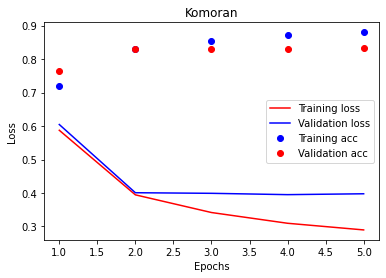

In [69]:
komoran_history_dict = komoran_history.history

komoran_acc = komoran_history_dict['accuracy']
komoran_val_acc = komoran_history_dict['val_accuracy']
komoran_loss = komoran_history_dict['loss']
komoran_val_loss = komoran_history_dict['val_loss']

epoch = range(1, len(komoran_acc) + 1)

plt.plot(epoch, komoran_loss, 'r', label='Training loss')
plt.plot(epoch, komoran_val_loss, 'b', label='Validation loss')
plt.plot(epoch, komoran_acc, 'bo', label='Training acc')
plt.plot(epoch, komoran_val_acc, 'ro', label='Validation acc')
plt.title('Komoran')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- 약 val_acc, test_acc 모두 83% 정도의 정확도를 보여줍니다.

---
## 7.3 Okt 모델

In [70]:
def okt_token(df, df2, num_words = 25000):
    okt = Okt()
    x_train = []
    
    df_len = len(df)
    df = pd.concat([df, df2], axis=0)
    df.reset_index(inplace=True)
    
    for i in tqdm(range(len(df))):
        x_train.append(okt.morphs(df['document'][i]))
        
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words, filters=" ", char_level=True)
    
    tokenizer.fit_on_texts(x_train)
    
    
    x_train = tokenizer.texts_to_sequences(x_train)
    x_train = np.array(list(x_train))
    
    x_train, x_test = x_train[:df_len], x_train[df_len:]
    y_train, y_test = np.array(df['label'][:df_len]), np.array(df['label'][df_len:])
    
    return x_train, y_train, x_test, y_test, tokenizer

In [71]:
x_train, y_train, x_test, y_test, okt_token = okt_token(train, test)

100%|██████████| 195339/195339 [1:10:52<00:00, 45.93it/s]


In [72]:
okt_word_to_idx = {}
okt_idx_to_word = {}
for i, v in okt_token.index_word.items():
    okt_word_to_idx[v] = i
    okt_idx_to_word[i] = v

100%|██████████| 146182/146182 [00:00<00:00, 927851.58it/s]


Train 데이터셋의 최대 길이: 76
Train 데이터셋의 최소 길이: 0
Train 데이터셋의 평균 길이: 12
Train 데이터셋의 총 길이: 1899484
--------------------------------------------------------------------------------------------------------------------------------


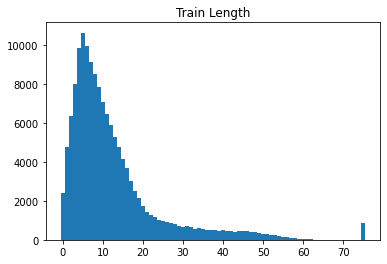

100%|██████████| 49157/49157 [00:00<00:00, 776061.65it/s]


Test 데이터셋의 최대 길이: 76
Test 데이터셋의 최소 길이: 0
Test 데이터셋의 평균 길이: 13
Test 데이터셋의 총 길이: 642458
--------------------------------------------------------------------------------------------------------------------------------


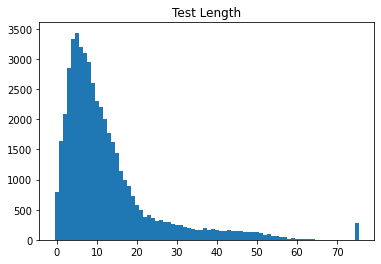

In [73]:
max_min_len(x_train, 'Train')
max_min_len(x_test, 'Test')

- 위와 동일한 과정을 거쳐 약 25의 길이분포를 얻었습니다.

In [74]:
x_train, y_train = clear_sentence(x_train, y_train, min_num = 1, max_num = 25)
x_test, y_test = clear_sentence(x_test, y_test, min_num = 1, max_num = 25, name='Test')

146182it [00:00, 992389.13it/s]


--------------------------------------------------------------------------------------------------------------------------------
전처리 전 Train 데이터의 길이: 146182
전처리 후 Train 데이터의 길이: 126719
--------------------------------------------------------------------------------------------------------------------------------


49157it [00:00, 823143.76it/s]

--------------------------------------------------------------------------------------------------------------------------------
전처리 전 Test 데이터의 길이: 49157
전처리 후 Test 데이터의 길이: 42479
--------------------------------------------------------------------------------------------------------------------------------


In [75]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, padding='post', maxlen= 25)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, padding='post', maxlen= 25)

In [76]:
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  random_state=42)

In [77]:
print(' 훈련 데이터셋의 길이: ',len(x_train),'\n', '벨리데이션 데이터셋의 길이: ', len(x_val))
print('----'*32)
print(' 훈련 라벨데이터셋의 길이: ', len(y_train), '\n', '벨리데이션 라벨데이터셋의 길이: ', len(y_val))
print('----'*32)

 훈련 데이터셋의 길이:  101375 
 벨리데이션 데이터셋의 길이:  25344
--------------------------------------------------------------------------------------------------------------------------------
 훈련 라벨데이터셋의 길이:  101375 
 벨리데이션 라벨데이터셋의 길이:  25344
--------------------------------------------------------------------------------------------------------------------------------


In [78]:
class okt_model(keras.Model):
    def __init__(self, vocab_size, embedding_size, units, drop_rate):
        super().__init__()
        self.Embedding = Embedding(vocab_size, embedding_size, mask_zero=True)
        self.lstm1 = LSTM(units, return_sequences=True, activation='tanh', dropout=drop_rate)
        self.batch1 = BatchNormalization()
        self.drop1 = Dropout(drop_rate)
        self.lstm2 = LSTM(units*2, activation='tanh', dropout=drop_rate)
        self.batch2 = BatchNormalization()
        self.drop2 = Dropout(drop_rate)
        self.dense = Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.Embedding(x)
        x = self.lstm1(x)
        x = self.batch1(x)
        x = self.drop1(x)
        x = self.lstm2(x)
        x = self.batch2(x)
        x = self.drop2(x)
        x = self.dense(x)
        
        return x

In [79]:
okt_model = okt_model(vocab_size, embedding_size, units, drop_rate)

okt_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

okt_history = okt_model.fit(x_train, y_train, batch_size=batch_size,\
                    verbose='auto', epochs=epochs,\
                    validation_data=(x_val, y_val), callbacks=[es])

Epoch 1/5
396/396 [==============================] - 40s 37ms/step - loss: 0.5736 - accuracy: 0.7235 - val_loss: 0.5016 - val_accuracy: 0.8325
Epoch 2/5
396/396 [==============================] - 9s 23ms/step - loss: 0.3636 - accuracy: 0.8451 - val_loss: 0.3595 - val_accuracy: 0.8438
Epoch 3/5
396/396 [==============================] - 9s 22ms/step - loss: 0.3144 - accuracy: 0.8683 - val_loss: 0.3724 - val_accuracy: 0.8437
Epoch 4/5
396/396 [==============================] - 9s 22ms/step - loss: 0.2859 - accuracy: 0.8817 - val_loss: 0.3908 - val_accuracy: 0.8404
Epoch 5/5
396/396 [==============================] - 9s 22ms/step - loss: 0.2644 - accuracy: 0.8914 - val_loss: 0.4039 - val_accuracy: 0.8416


In [80]:
okt_test = okt_model.evaluate(x_test, y_test, verbose=2)

1328/1328 - 17s - loss: 0.4078 - accuracy: 0.8412


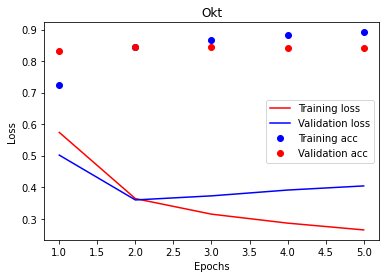

In [81]:
okt_history_dict = okt_history.history

okt_acc = okt_history_dict['accuracy']
okt_val_acc = okt_history_dict['val_accuracy']
okt_loss = okt_history_dict['loss']
okt_val_loss = okt_history_dict['val_loss']

epoch = range(1, len(okt_acc) + 1)

plt.plot(epoch, okt_loss, 'r', label='Training loss')
plt.plot(epoch, okt_val_loss, 'b', label='Validation loss')
plt.plot(epoch, okt_acc, 'bo', label='Training acc')
plt.plot(epoch, okt_val_acc, 'ro', label='Validation acc')
plt.title('Okt')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- 약 84% 정확도를 보여줍니다.
- 모두 비슷한 양상의 그래프를 보여주는군요.

---
## 8. 종합 결과 확인

In [82]:
token_list = [s_uni_history_dict, mecab_history_dict, komoran_history_dict, okt_history_dict]
token_names = ['Sentence_piece_unigram','Mecab', 'Komoran', 'Okt']
acc_list = ['accuracy', 'val_accuracy']

def acc_df(token_list, token_names, acc_list):
    count = 0
    for token in token_list:
        for num in range(1):
            if num == 1:
                continue
            s1 = round(pd.Series(token[acc_list[num]][-1], index=[token_names[count]]), 4)
            s2 = round(pd.Series(token[acc_list[num+1]][-1], index=[token_names[count]]), 4)
            if token == token_list[0]:
                s = pd.concat([s1, s2], axis=1)
            elif token != token_list[0]:
                other = pd.concat([s1, s2], axis=1)
                s = pd.concat([s, other], axis=0)
            count += 1
    s.rename(columns={0: acc_list[0], 1: acc_list[1]}, inplace=True)
    
    return s

In [83]:
test_list = [s_uni_test, mecab_test, komoran_test, okt_test]

def test_loss_acc(test_list, token_names):
    count = 0
    for test in test_list:
        s1 = round(pd.Series(test[0], index=[token_names[count]]), 4)
        s2 = round(pd.Series(test[1], index=[token_names[count]]), 4)
        if test == test_list[0]:
            s = pd.concat([s1, s2], axis=1)
        elif test != test_list[0]:
            other = pd.concat([s1, s2], axis=1)
            s = pd.concat([s, other], axis=0)
        count += 1
    s.rename(columns={0: 'Test loss', 1:'Test Accuracy'}, inplace=True)
    
    return s

- 결과값을 pandas 데이터프레임 형태로 보여주는 함수를 만들었습니다.

In [84]:
result = acc_df(token_list, token_names, acc_list)

result

,accuracy,val_accuracy
Sentence_piece_unigram,0.8837,0.8496
Mecab,0.8853,0.8474
Komoran,0.8803,0.8335
Okt,0.8914,0.8416


- train_acc 에서는 Okt
- val_acc 에서는 Sentencepiece 가 가장 높은 수치를 보입니다.

In [85]:
test_result = test_loss_acc(test_list, token_names)
test_result

,Test loss,Test Accuracy
Sentence_piece_unigram,0.3556,0.8524
Mecab,0.3836,0.8442
Komoran,0.3963,0.8374
Okt,0.4078,0.8412


- test 데이터에 대해서는 모두 Sentencepiece가 가장 우세합니다.

In [86]:
total_result = pd.concat([result, test_result], axis=1)
total_result

,accuracy,val_accuracy,Test loss,Test Accuracy
Sentence_piece_unigram,0.8837,0.8496,0.3556,0.8524
Mecab,0.8853,0.8474,0.3836,0.8442
Komoran,0.8803,0.8335,0.3963,0.8374
Okt,0.8914,0.8416,0.4078,0.8412


- 종합적으로 보니 훨씬 깔끔하군요.

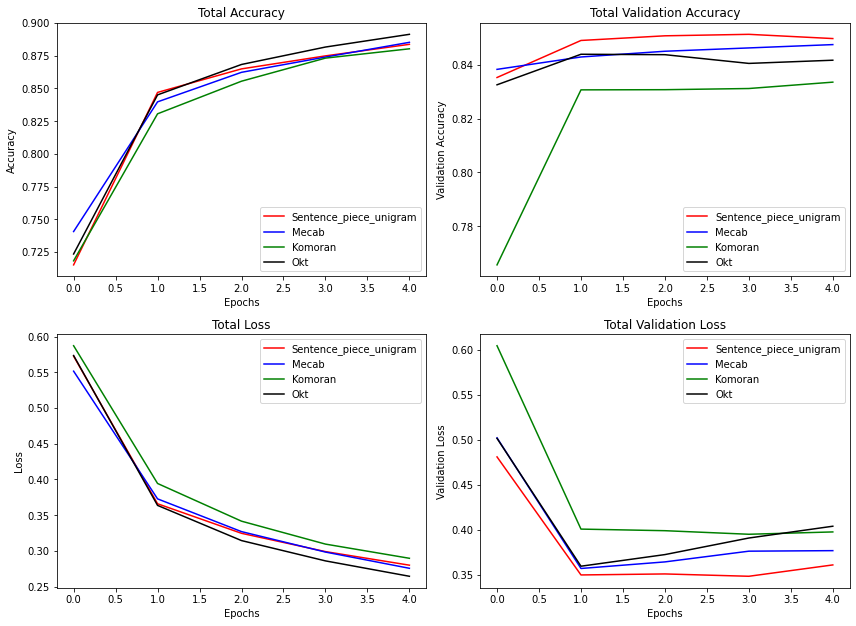

,accuracy,val_accuracy,Test loss,Test Accuracy
Sentence_piece_unigram,0.8837,0.8496,0.3556,0.8524
Mecab,0.8853,0.8474,0.3836,0.8442
Komoran,0.8803,0.8335,0.3963,0.8374
Okt,0.8914,0.8416,0.4078,0.8412


In [92]:
fig, ax = plt.subplots(2,2, figsize=(12,8))

result_epoch = range(len(s_uni_acc))

plt.subplot(221)
plt.plot(result_epoch, s_uni_acc, 'r', label='Sentence_piece_unigram')
plt.plot(result_epoch, mecab_acc, 'b', label='Mecab')
plt.plot(result_epoch, komoran_acc, 'g', label='Komoran')
plt.plot(result_epoch, okt_acc, 'k', label='Okt')
plt.title('Total Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(222)
plt.plot(result_epoch, s_uni_val_acc, 'r', label='Sentence_piece_unigram')
plt.plot(result_epoch, mecab_val_acc, 'b', label='Mecab')
plt.plot(result_epoch, komoran_val_acc, 'g', label='Komoran')
plt.plot(result_epoch, okt_val_acc, 'k', label='Okt')
plt.title('Total Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()

plt.subplot(223)
plt.plot(result_epoch, s_uni_loss, 'r', label='Sentence_piece_unigram')
plt.plot(result_epoch, mecab_loss, 'b', label='Mecab')
plt.plot(result_epoch, komoran_loss, 'g', label='Komoran')
plt.plot(result_epoch, okt_loss, 'k', label='Okt')
plt.title('Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(224)
plt.plot(result_epoch, s_uni_val_loss, 'r', label='Sentence_piece_unigram')
plt.plot(result_epoch, mecab_val_loss, 'b', label='Mecab')
plt.plot(result_epoch, komoran_val_loss, 'g', label='Komoran')
plt.plot(result_epoch, okt_val_loss, 'k', label='Okt')
plt.title('Total Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.tight_layout(rect=(0,0,1,1.1))
plt.legend()

plt.show()

total_result

- 그래프로 보니 모두 비슷한 느낌의 성향을 보여줍니다. 하지만 거의 모든 그래프에서 Sentencepiece가 가장 우세한걸 확인할 수 있습니다.
- 대체적으로 Komoran이 아쉬운 느낌을 주는군요.

---
## 9. 회고

### 이번 프로젝트를 하면서 어려웠던 점
>- 이번 프로젝트는 첫 going_deeper 프로젝트라 많이 걱정되었는데 특히나 SPM이라는 처음써보는 외부모델이어서 그런지 많이 낯설고 사용법도 어려웠습니다. 하지만 하다보니 적응도 되고 이번 프로젝트 자체가 생각했던 것보다 어렵지 않았고 오히려 예시코드가 없으니 마음대로 짜고 꾸밀수 있는것이 재밌게 다가왔습니다. 
### 이번 프로젝트에서 학습한 내용
>- 이번 프로젝트에서는 특히나 Sentencepiece 모델에 관하여 많이 학습하게 된것 같습니다. 각각의 파라미터의 역할, 파라미터의 종류, 파라미터 호출 방법 또한 외부모델 사용법 등 학습한 내용이 상당히 많았고 이전에 사용하던 pandas, matplotlib 과 같은 라이브러리를 다시 한번 공부할 수 있어서 좋았습니다.
>  
>  
>- 또한 신경망을 쌓는 과정에서 지금까지 제대로 써보지 못했던 subclassing model을 쌓아봤는데 은근 쌓는 과정이 재미도 있고 신기했습니다. 앞으로 많이 사용해보며 익숙해져야할듯 합니다. 
### 알아낸 점이나 모호한 점
>- 많이 알아보았지만 Sentencepiece의 각 파라미터들의 정확한 기능은 확인하지 못했으며 사용해보려하면 오류가 뜨고 시간이 너무 오래걸리는 바람에 하지 못한것이 많습니다. 앞으로 사용하게 될 모델인지는 모르겠지만 천천히 알아보려 합니다.
### 루브릭 평가지표를 맞추기 위해 노력했던 점
>- __1. 코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?__ 에 대해서는 코퍼스 분석, 전처리, Sentencepiece 적용, 토크나이저 등 모두 커스텀하여 구현하였고 동작이 잘 됨을 확인할 수 있었습니다.
>- __2. SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.__ 에 대해서는 train_accuracy 88%, validation_accuracy 85%, test_accuracy 85% 정도의 수치로 정상적으로 수렴하였고 좋은 성능을 이끌어 냈습니다.
>- __3. SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.__ 을 위해서는 다른 파라미터를 가진 모델들과 비교해보았으나 큰 차이는 없었기에 위에 기술하지 않았습니다. 특히나 unigram이 아닌 bpe와 비교해보고싶었으나 bpe는 시간이 너무나 오래걸리는듯 하여 실행해보지 못했습니다. 약 4시간 이상 지켜보았으나 아무런 결과를 보이지 않아 bpe는 load에서부터 문제가 생긴다 판단해 해보지 못했습니다. 때문에 위 코드에서 주석처리해서 코드블럭은 남겨 놓았습니다. 그리고 bpe 대신 다른 Sentencepiece의 옵션 대신 한국어 형태소 분석기인 Mecab, Okt, Komoran과 함께 분석하였습니다. 이 또한 Kkma, Hannanum과도 비교해보고싶었으나 Hannanum은 오류로 인해 진행할 수 없었고 Kkma는 토큰화 과정이 10시간이 넘게 걸리는 바람에 할 수 없었습니다. 그래서 결국 Sentencepiece unigram과 Mecab, Okt, Komoran 4개의 값들을 서로 비교하였습니다.
### 루브릭 평가지표를 달성하지 못헀다면 이유
>- 아무래도 3번 루브릭이 아닐까 싶습니다. 이유로는 Sentencepiece의 다른 모델인 bpe 모델이 실행되지 않아 비교해보지 못했고 다른 파라미터를 사용한 옵션의 경우엔 전혀 성능차이를 보이지 않았기에 위의 회고에서 대략적인 기술만 하였기 때문이 아닐까 싶습니다.

---
## 10. Reference

>- [Sentence Piece github](https://github.com/google/sentencepiece)
>- [Sentence Piece 관련 Tistory](https://lsjsj92.tistory.com/600)
>- [Sentence Piece 관련 velog](https://velog.io/@gibonki77/SentencePiece)
>- [Tensorflow 공식문서](https://www.tensorflow.org/)
>- [matplotlib 공식문서](https://matplotlib.org/stable/api/index.html)
>- [pandas 공식문서](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html)

---
## 11. 자기다짐 및 아쉬운 점

- 이번 프로젝트에서 bpe 모델을 해보지 못한 점이 너무 아쉽습니다. 위의 코드블럭은 실행되지 않은 아쉬움에 모두 남겨놓았습니다. 앞으로 사용할 기회가 된다면 그땐 다시 사용해볼 생각입니다.
  
  
- 이번 프로젝트는 상당히 좋은 프로젝트였습니다. 제 수준이 어느정도인지 파악하기 좋았고 예시코드가 없을지라도 나도 혼자 할 수 있구나 라는걸 느낄 수 있었습니다. 앞으로 더욱 재밌는 프로젝트가 많이 나왔으면 좋겠다는 생각입니다.